![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Finite-volume-based CFD in a nutshell

Outline of this notebook

1. Mathematical problem
2. Domain discretization (meshing)
3. Equation discretization
4. Iterative solution
5. Post-processing

## Mathematical problem

In [1]:
import matplotlib.pyplot as plt
import torch as pt

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

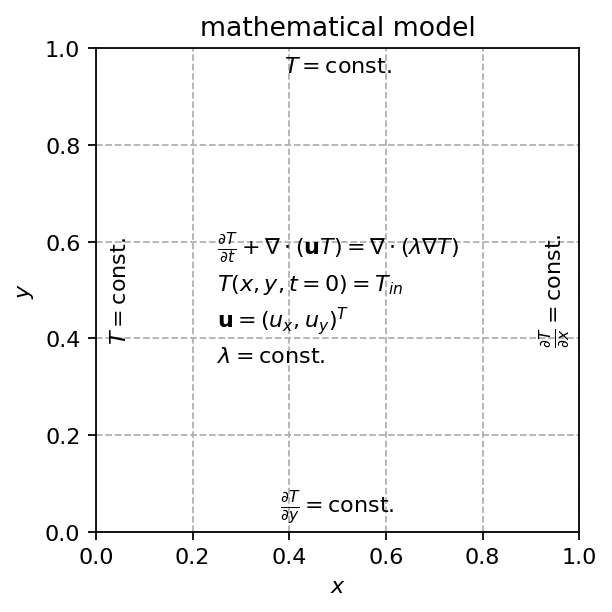

In [245]:
fig, ax = plt.subplots()
ax.set_title("mathematical model")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.text(0.5, 0.95, r"$T=\mathrm{const.}$", ha="center")
ax.text(0.5, 0.05, r"$\frac{\partial T}{\partial y} = \mathrm{const.}$", ha="center", va="center")
ax.text(0.05, 0.5, r"$T= \mathrm{const.}$", ha="center", va="center", rotation=90)
ax.text(0.95, 0.5, r"$\frac{\partial T}{\partial x} = \mathrm{const.}$", ha="center", va="center", rotation=90)
dt_T = r"\frac{\partial T}{\partial t}"
div_T = r"\nabla\cdot\left(\mathbf{u}T\right)"
laplace_T = r"\nabla\cdot\left(\lambda \nabla T\right)"
ax.text(0.25, 0.575, r"${:s} + {:s} = {:s}$".format(dt_T, div_T, laplace_T), ha="left")
ax.text(0.25, 0.5, r"$T(x,y, t=0) = T_{in}$", ha="left")
ax.text(0.25, 0.425, r"$\mathbf{u} = \left(u_x, u_y\right)^T$", ha="left")
ax.text(0.25, 0.35, r"$\lambda = \mathrm{const.}$", ha="left")
ax.set_aspect("equal")
ax.grid(ls="--")
plt.savefig(f"{output}/fvm_mathematical_model.svg", bbox_inches="tight")

In [3]:
def stream_function(x, y, A):
    return 2*A*x*y

def velocity_field(x, y, A):
    u_x = 2*A*x
    u_y = -2*A*y
    return u_x, u_y

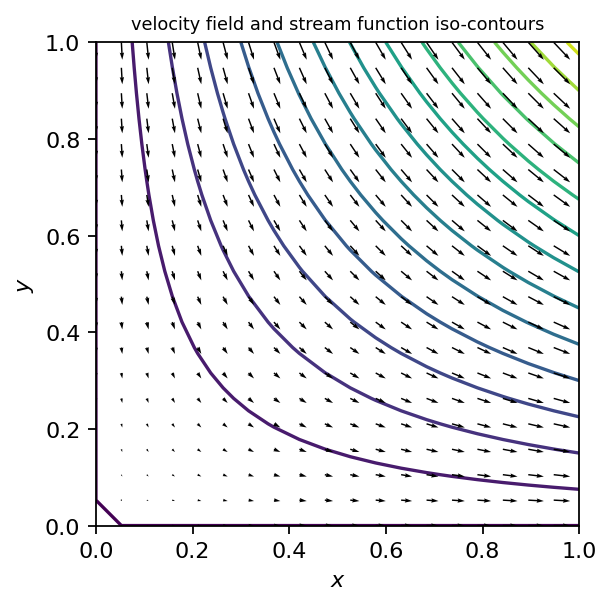

In [4]:
fig, ax = plt.subplots()

A = 1
N = 20
x = pt.linspace(0, 1, N)
y = pt.linspace(0, 1, N)
xx, yy = pt.meshgrid(x, y)
psi = stream_function(xx, yy, A)
u_x, u_y = velocity_field(xx, yy, A)
ax.contour(xx, yy, psi, levels=15)
ax.quiver(xx, yy, u_x, u_y, zorder=6)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_aspect("equal")
ax.set_title("velocity field and stream function iso-contours", fontsize=8)
plt.savefig(f"{output}/2D_velocity_field.svg", bbox_inches="tight")

## Domain discretization (meshing)

In [5]:
class Mesh(object):
    def __init__(self, L_x, L_y, N_x, N_y, grad_x, grad_y):
        self.L_x = L_x
        self.L_y = L_y
        self.N_x = N_x
        self.N_y = N_y
        self.dx = self._compute_cell_width(L_x, N_x, grad_x)
        self.dy = self._compute_cell_width(L_y, N_y, grad_y)
        self.x = pt.cumsum(self.dx, 0) - self.dx * 0.5
        self.y = pt.cumsum(self.dy, 0) - self.dy * 0.5
        xf = self.x - self.dx * 0.5
        self.xf = pt.cat((xf, pt.tensor([xf[-1]+self.dx[-1]])))
        yf = self.y - self.dy * 0.5
        self.yf = pt.cat((yf, pt.tensor([yf[-1]+self.dy[-1]])))

    def _compute_cell_width(self, L, N, grad):
        if grad == 1.0:
            delta = L / N
            return pt.ones(N) * delta
        else:
            cell_widths = pt.linspace(1.0, grad, N)
            width_0 = L / cell_widths.sum()
            return cell_widths * width_0

    def cell_id(self, i, j) -> int:
        return self.N_x * j + i

    def visualize(self, show_ids=True):
        fig, ax = plt.subplots()
        xx, yy = pt.meshgrid(self.x, self.y)
        ax.scatter(xx, yy, s=5, c="k", zorder=6)
        for xf_i, yf_i in zip(self.xf, self.yf):
            ax.axvline(xf_i, 0.0, self.L_x, ls="--", c="k", alpha=0.3)
            ax.axhline(yf_i, 0.0, self.L_y, ls="--", c="k", alpha=0.3)
        fontsize = int(10*5/self.N_x)
        if show_ids:
            for i in range(self.N_x):
                for j in range(self.N_y):
                    ax.text(self.x[i], self.y[j]+0.2*self.dy[j], f"({i},{j})",
                            ha="center", va="center", fontsize=fontsize)
                    ax.text(self.x[i], self.y[j]-0.2*self.dy[j], f"{self.cell_id(i, j)}",
                            ha="center", va="center", fontsize=fontsize)
        ax.set_xlim(-0.01, self.L_x+0.01)
        ax.set_ylim(-0.01, self.L_y+0.01)
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_aspect("equal")
        ax.set(frame_on=False)
        return fig, ax


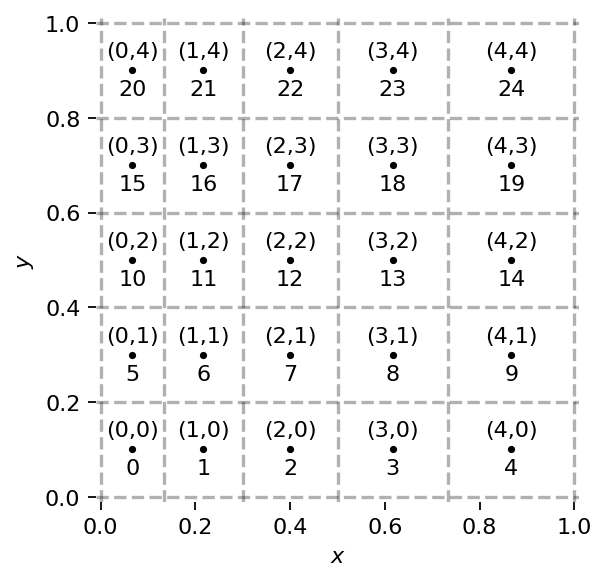

In [246]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
assert pt.allclose(mesh.xf, pt.linspace(0.0, 1.0, 6))
assert pt.allclose(mesh.x, pt.linspace(0.1, 0.9, 5))
mesh = Mesh(1.0, 1.0, 5, 5, 2.0, 1.0)
assert pt.isclose(2.0*mesh.dx[0], mesh.dx[-1])
fig, ax = mesh.visualize()
plt.savefig(f"{output}/5x5_mesh.svg", bbox_inches="tight")

In [242]:
class VolScalarField(object):
    def __init__(self, mesh, name, value, bc):
        self.mesh = mesh
        self.name = name
        self.internal_field = pt.ones((mesh.N_x, mesh.N_y))
        self.internal_field *= value
        self.bc = bc

    def visualize(self):
        fig, ax = self.mesh.visualize(False)
        ax.set_title(f"internal field {self.name}")
        pc = ax.pcolormesh(self.mesh.xf, self.mesh.yf, self.internal_field, label=f"{self.name}")
        plt.colorbar(pc, ax=ax)
        return fig, ax

    def __equal__(self, other):
        return self is other

In [20]:
T1 = VolScalarField(mesh, "T", 0.0)
T2 = VolScalarField(mesh, "T", 0.0)
assert T1 == T1
assert not T1 == T2

In [255]:
class FVMatrix(object):
    def __init__(self, matrix, source, field):
        self.matrix = matrix
        self.source = source
        self.field = field

    def __add__(self, other):
        assert self.field == other.field
        return FVMatrix(self.matrix + other.matrix,
                        self.source + other.source,
                        self.field)
    
    def visualize(self, scale=10):
        fig, ax = plt.subplots()
        # coefficient matrix
        elements = self.field.mesh.N_x*self.field.mesh.N_y
        ax.set_xticks(range(elements))
        ax.set_yticks(range(elements))
        i, j = self.matrix._indices()
        colors = []
        for c in range(i.shape[0]):
            if self.matrix._values()[c] < 0.0:
                colors.append("C0")
            else:
                colors.append("C1")
        ax.scatter(i, j, s=self.matrix._values().abs()*scale, c=colors, zorder=6)
        colors = []
        for c in range(self.source.shape[0]):
            if self.source[c] < 0.0:
                colors.append("C0")
            else:
                colors.append("C1")
        ax.scatter(pt.ones(elements)*(elements+1), range(elements),  s=self.source.abs()*scale, c=colors, zorder=6)
        ax.axvline(elements, 0, 1, ls="-", c="k")
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(True, ls="--")
        ax.set_aspect(True)
        ax.set_xlim(-1, elements+2)
        ax.set_ylim(-1, elements)
        ax.invert_yaxis()
        ax.xaxis.set_ticks_position('top')
        return fig, ax

In [258]:
indices = [[3, 6, 9, 12, 15, 18], [12, 15, 18, 21, 24, 24]]
values = [1, 2, 3, -1, -2, -3]
test_matrix = pt.sparse_coo_tensor(indices, values)
test_source = pt.linspace(1, 3, 25)
A1 = FVMatrix(test_matrix, test_source, T1)
A2 = FVMatrix(test_matrix, test_source, T1)
A3 = FVMatrix(test_matrix, test_source, T2)
assert pt.allclose((A1 + A2).matrix.to_dense(), 2*test_matrix.to_dense())
try:
    A1 + A3
except:
    print("Could not add matrices due to field missmatch.")

Could not add matrices due to field missmatch.


(<Figure size 960x640 with 1 Axes>, <AxesSubplot:>)

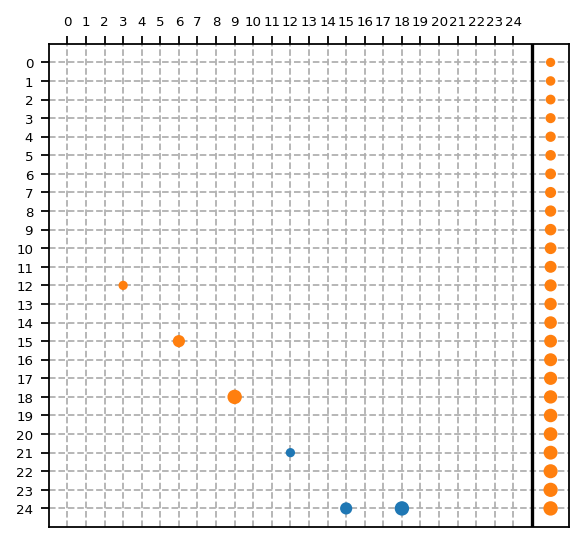

In [259]:
A1.visualize()

In [220]:
def fvm_laplace(diffusivity, field) -> FVMatrix:
    row, col, val = [], [], []
    dx, dy = field.mesh.dx, field.mesh.dy
    source = pt.zeros(field.mesh.N_x*field.mesh.N_y)
    def add_east(i, j):
        if i < field.mesh.N_x-1:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i+1, j))
            val.append(
                2.0*diffusivity*dy[j] / (dx[i+1]+dx[i])
            )
    def add_west(i, j):
        if i > 0:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i-1, j))
            val.append(
                2.0*diffusivity*dy[j] / (dx[i]+dx[i-1])
            )
    def add_north(i, j):
        if j < field.mesh.N_y-1:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i, j+1))
            val.append(
                2.0*diffusivity*dx[i] / (dy[j+1]+dy[j])
            )
    def add_south(i, j):
        if j > 0:
            row.append(field.mesh.cell_id(i, j))
            col.append(field.mesh.cell_id(i, j-1))
            val.append(
                2.0*diffusivity*dx[i] / (dy[j]+dy[j-1])
            )
    def add_center(i, j):
        internal = 0 < i < field.mesh.N_x-1 and 0 < j < field.mesh.N_y-1

        if internal:
            fe = 1.0/(dx[i+1]+dx[i])
            fw = 1.0/(dx[i]+dx[i-1])
            fn = 1.0/(dy[j+1]+dy[j])
            fs = 1.0/(dy[j]+dy[j-1])
        else:
            type_e, val_e = field.bc["right"]
            type_w, val_w = field.bc["left"]
            type_n, val_n = field.bc["top"]
            type_s, val_s = field.bc["bottom"]
            fe, fw, fn, fs = 1.0, 1.0, 1.0, 1.0
            # left boundary
            if i == 0:
                fe = 1.0/(dx[i+1]+dx[i])
                fw = 1.0/dx[i] if type_w == "fixedValue" else 0.0
                if j == 0:
                    fs = 1.0/dy[j] if type_s == "fixedValue" else 0.0
                else:
                    fs = 1.0/(dy[j]+dy[j-1])
                if j == field.mesh.N_y - 1:
                    fn = 1.0/dy[j] if type_n == "fixedValue" else 0.0
                else:
                    fn = 1.0/(dy[j+1]+dy[j])
            # right boundary
            elif i == field.mesh.N_x - 1:
                fw = 1.0/(dx[i]+dx[i-1])
                fe = 1.0/dx[i] if type_e == "fixedValue" else 0.0
                if j == 0:
                    fs = 1.0/dy[j] if type_s == "fixedValue" else 0.0
                else:
                    fs = 1.0/(dy[j]+dy[j-1])
                if j == field.mesh.N_y - 1:
                    fn = 1.0/dy[j] if type_n == "fixedValue" else 0.0
                else:
                    fn = 1.0/(dy[j+1]+dy[j])
            
            else:
                fe = 1.0/(dx[i+1]+dx[i])
                fw = 1.0/(dx[i]+dx[i-1])
                # bottom boundary
                if j == 0:
                    fs = 1.0/dy[j] if type_s == "fixedValue" else 0.0
                else:
                    fs = 1.0/(dy[j]+dy[j-1])
                # top boundary
                if j == field.mesh.N_y - 1:
                    fn = 1.0/dy[j] if type_n == "fixedValue" else 0.0
                else:
                    fn = 1.0/(dy[j+1]+dy[j])
        row.append(field.mesh.cell_id(i, j))
        col.append(field.mesh.cell_id(i, j))
        val.append(
                -2.0*diffusivity*dy[j] * (fe + fw)
                -2.0*diffusivity*dx[i] * (fn + fs)
        )
    def add_source(i, j):
        internal = 0 < i < field.mesh.N_x-1 and 0 < j < field.mesh.N_y-1
        if not internal:
            type_e, val_e = field.bc["right"]
            type_w, val_w = field.bc["left"]
            type_n, val_n = field.bc["top"]
            type_s, val_s = field.bc["bottom"]
            sp = 0.0
            fac_1 = 2.0*diffusivity*dy[j]
            fac_2 = 2.0*diffusivity*dx[i]
            # left
            if i == 0:
                sp -= fac_1*val_w/dx[i] if type_w == "fixedValue" else fac_1*val_w
                if j == 0:
                    sp -= fac_2*val_s/dy[j] if type_s == "fixedValue" else fac_2*val_s
                if j == field.mesh.N_y-1:
                    sp -= fac_2*val_n/dy[j] if type_n == "fixedValue" else fac_2*val_n
            # right
            elif i == field.mesh.N_x - 1:
                sp -= fac_1*val_e/dx[i] if type_e == "fixedValue" else fac_1*val_e
                if j == 0:
                    sp -= fac_2*val_s/dy[j] if type_s == "fixedValue" else fac_2*val_s
                if j == field.mesh.N_y-1:
                    sp -= fac_2*val_n/dy[j] if type_n == "fixedValue" else fac_2*val_n
            else:
                # bottom
                if j == 0:
                    sp -= fac_2*val_s/dy[j] if type_s == "fixedValue" else fac_2*val_s
                # top
                elif j == field.mesh.N_y-1:
                    sp -= fac_2*val_n/dy[j] if type_n == "fixedValue" else fac_2*val_n
            source[field.mesh.cell_id(i, j)] = sp

    for i in range(field.mesh.N_x):
        for j in range(field.mesh.N_y):
            add_center(i, j)
            add_east(i, j)
            add_west(i, j)
            add_north(i, j)
            add_south(i, j)
            add_source(i, j)
        
    return FVMatrix(pt.sparse_coo_tensor([row, col], val),
                    source, field)


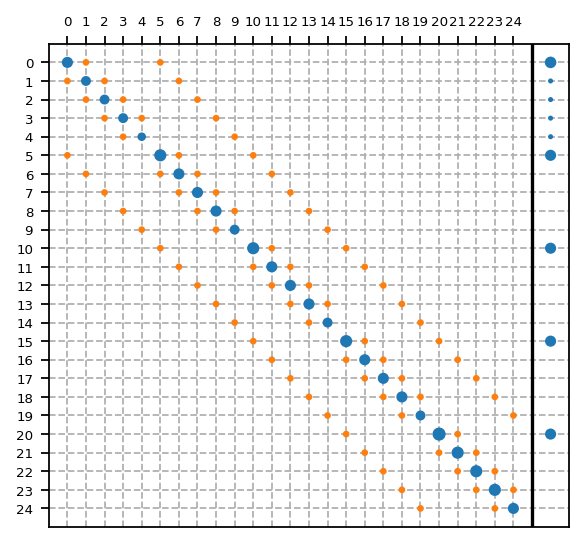

In [260]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", 0.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", 1.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
matrix = fvm_laplace(1.0, T)
fig, ax = matrix.visualize(scale=4)
plt.savefig(f"{output}/diff_fv_matrix.svg", bbox_inches="tight")

## Iterative solution

### Jacobi and Gauss-Seidel method

In [69]:
x, y = 0, 0
x_true, y_true = -8, 3
TOL = 1e-3
res_jacobi = []
for i in range(50):
    x_new = (2 + 2*y) / (-1)
    y_new = (-5 + 2*x) / (-7)
    x, y = x_new, y_new
    res_jacobi.append(abs(x-x_true) + abs(y-y_true))
    if res_jacobi[-1] < TOL:
        print(f"Converged after {i+1} iterations.")
        break

Converged after 34 iterations.


In [70]:
x, y = 0, 0
res_gauss_seidel = []
for i in range(50):
    x = (2 + 2*y) / (-1)
    y = (-5 + 2*x) / (-7)
    res_gauss_seidel.append(abs(x-x_true) + abs(y-y_true))
    if res_gauss_seidel[-1] < TOL:
        print(f"Converged after {i+1} iterations.")
        break

Converged after 17 iterations.


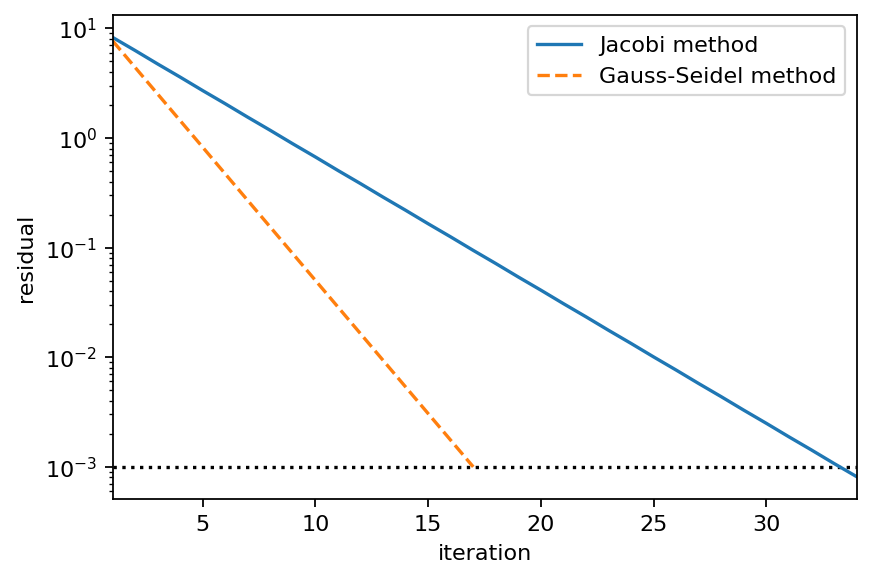

In [78]:
plt.plot(range(1, len(res_jacobi)+1), res_jacobi, ls="-", label="Jacobi method")
plt.plot(range(1, len(res_gauss_seidel)+1), res_gauss_seidel, ls="--", label="Gauss-Seidel method")
plt.hlines(TOL, 1, len(res_jacobi), colors="k", ls=":")
plt.xlabel("iteration")
plt.ylabel("residual")
plt.xlim(1, len(res_jacobi))
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/jacobi_vs_gauss_seidel.svg", bbox_inches="tight")

### Sparse versus dense matrices

In [9]:
def compute_n_elements_dense(Nx: int, Ny: int) -> int:
    return (Nx*Ny)**2

def compute_n_elements_sparse(Nx: int, Ny: int) -> int:
    four_nb = (Nx-2) * (Ny-2)
    three_nb = 2*(Nx-2) + 2*(Ny-2)
    two_nb = 4
    return (four_nb*5 + three_nb*4 + two_nb*3) * 3

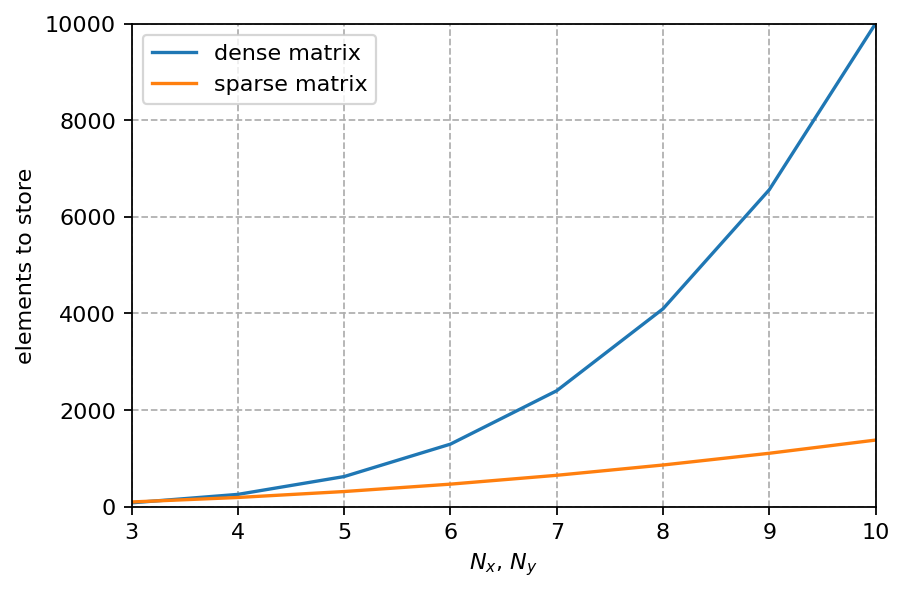

In [17]:
N_cells = range(3, 11)
N_float_dense = [compute_n_elements_dense(n, n) for n in N_cells]
N_float_sparse = [compute_n_elements_sparse(n, n) for n in N_cells]

plt.plot(N_cells, N_float_dense, label="dense matrix")
plt.plot(N_cells, N_float_sparse, label="sparse matrix")
plt.xlabel(r"$N_x$, $N_y$")
plt.ylabel("elements to store")
plt.legend()
plt.xlim(3, 10)
plt.ylim(0, 1e4)
plt.grid(ls="--")
plt.savefig(f"{output}/dense_vs_sparse.svg", bbox_inches="tight")

In [203]:
def gauss_seidel(A, b, x, tol=1.0e-6, max_iter=1000):
    for it in range(max_iter):
        for i in range(x.shape[0]):
            row_sum = 0.0
            for row, col in zip(*A._indices()):
                if row == i and col != i:
                    row_sum += (A[row, col] * x[col]).item()
            x[i] = (b[i] - row_sum) / A[i, i]
        res = pt.linalg.norm(b - A.mv(x))
        if res < tol:
            print(f"Linear solver converged in {it+1} iterations.")
            print("Final residual: {:2.2e}".format(res))
            return x
    print(f"Linear solver did not converge after {it+1} iterations.")
    print("Final residual: {:2.2e}".format(res))
    return x


In [269]:
mesh = Mesh(1.0, 1.0, 5, 5, 1.0, 1.0)
bc = {
    "left" : ("fixedValue", 2.0),
    "right" : ("fixedGradient", 0.0),
    "top" : ("fixedValue", 0.0),
    "bottom" : ("fixedGradient", 1.0),
}
T = VolScalarField(mesh, "T", 0.0, bc)
matrix = fvm_laplace(0.1, T)

Tsol = gauss_seidel(matrix.matrix, matrix.source, matrix.field.internal_field.flatten(), tol=1.0e-2)
T = VolScalarField(mesh, "T", Tsol.reshape(5, 5), bc)

Linear solver converged in 22 iterations.
Final residual: 9.13e-03


## Post-processing

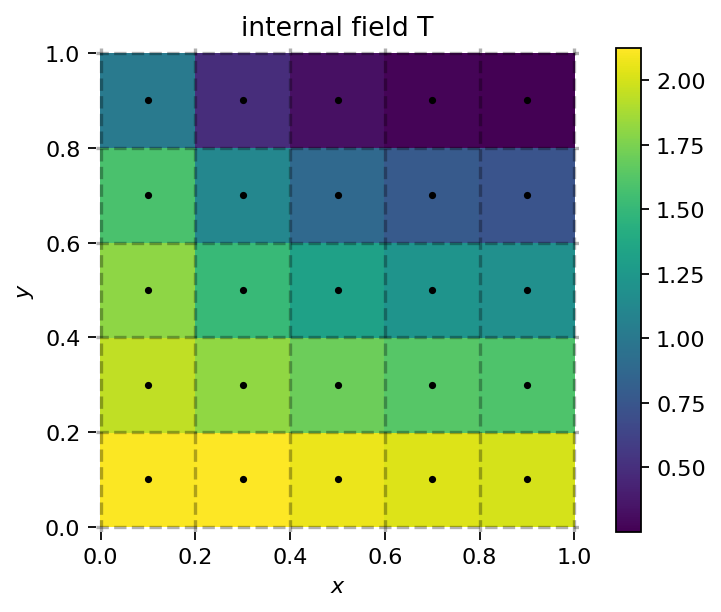

In [270]:
fig, ax = T.visualize()
plt.savefig(f"{output}/5x5_solution.svg", bbox_inches="tight")